# Imports

In [1]:
#no warnings about floating precision
import warnings
warnings.filterwarnings('ignore')

In [2]:
# LIMIT GPU MEMORY TAKEN UP BY THE NOTEBOOK
# you can specify the fraction of the AVAILABLE GPU memory that will be
# pre-allocated (jax default is .9)

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

#use another GPU if the default one is occupied
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import jax
import jax.numpy as np

from jax.random import split, PRNGKey
from jax import lax

jax.config.update('jax_debug_nans', True)

### NOTE: f32 gives > 3x speedup wrt f64
#config.update('jax_enable_x64', True)

#use this line to set the device to be used for the computations
#print(jax.devices())
#DOES NOT RECOGNIZE THE OPTION NAME FTM
#jax.config.update('jax_default_device', jax.devices()[1])

import equinox as eqx

import haiku as hk

from functools import partial

In [4]:
from jax_md import space
import jax_md.dataclasses as jdc

In [5]:
import jax_morph

from jax_morph.visualization import draw_circles_ctype, draw_circles_chem, draw_circles_divrate

from jax_morph.datastructures import SpaceFunc #, CellState
from jax_morph.simulation import simulation, sim_trajectory

from jax_morph.cell_division import S_cell_division
from jax_morph.cell_growth import S_grow_cells

from chem_twotypes.mechanical import S_mechmin_twotypes
from chem_twotypes.secdiff import S_ss_chemfield, sec_nn
from chem_twotypes.divrates import S_set_divrate, div_nn

from chem_twotypes.initial_states import init_state_grow

In [6]:
import matplotlib.pyplot as plt

from tqdm import tqdm

# Set Parameters

In [7]:
ParamsDict = dict

In [8]:
# Define parameters -- blue particles are type 1, orange are type 2
# keep jax type casting to place vars in gpu memory

# Number of chemical signals
n_chem = 3
n_celltype = 1

#-------------------------------------------------------------------------------
### NEW CLEAN VERSION

#rows are ctypes, cols are chemicals
#1 if ct secretes chem, 0 otw
#needs to be array for indexing

#ctype_sec_chem = np.identity(n_chem, dtype=np.int16) #each ct secretes one chem
ctype_sec_chem = np.ones((n_celltype,n_chem), dtype=np.int16) #every ct secretes everything
#ctype_sec_chem = np.hstack([np.identity(2)])


### CELL DIMENSIONS

#change constants in divrate calculation if cellRad != .5 
# always use python scalars
cellRad = .5
cellRadBirth = float(cellRad / np.sqrt(2))


### DIFFUSION

#possibly different diffusion and degradation for each chemical
diffCoeff = np.ones(n_chem) #np.linspace(.5,n_chem/2+1,n_chem) # #np.array([1.,3.]) #np.ones(n_chem)
degRate = np.ones(n_chem) #np.array([1.,1.])

#diffusion cutoff
r_cutoffDiff = 5.*cellRad
r_onsetDiff = r_cutoffDiff - .5


### SECRETION

# sec rate that gives concentration 1 at source at SS
sec_max_unitary = 2*np.sqrt(diffCoeff*degRate)

sec_max = np.ones((n_chem,), dtype=np.float32)
#sec_max = sec_max.at[0].set(20.)
#sec_max = sec_max.at[1].set(2.)


sec_gamma = .5* np.ones((n_chem,n_chem), dtype=np.float32) #was 0.01
sec_k = 1.*np.ones((n_chem,n_chem), dtype=np.float32) 


# # DIVISION

div_gamma = 2.*np.ones(n_chem, dtype=np.float32)
div_k = 1.*np.ones(n_chem, dtype=np.float32)
# div_k = div_k.at[0].set(3.)


# MORSE POTENTIAL
# always use python scalars
alpha = 3.
eps_TwoTwo = 3. #orange
eps_OneOne = 3. #blue
eps_OneTwo = 3. 

#morse cutoff
r_cutoff = 4.*cellRad
r_onset = r_cutoff - .2


# number of gradient descent steps for potential minimization
mech_relaxation_steps = 50


# Initialization and number of added cells. 
ncells_init = 2 #number of cells in the initial cluster
n_ones_init = ncells_init #number of type-1 cell in the initail cluster
ncells_add = 18
#ncells_tot =  np.int16(ncells_init+ncells_add)# final number of cells

#assert ncells_init > n_ones_init

In [9]:
#equinox automatically treats as static all non-array values
#cast floats/ints into arrays if the parameter needs a gradient

def _maybe_array(name, value, train_params):
    if train_params[name]:
        return np.array(value)
    else:
        return value

In [10]:
train_params = {
    'n_chem': False,
    #'secreted_by_ctypes': False,
    'ctype_sec_chem': False,
    
    'sec_max': True,
    
    'sec_gamma': False,
    'sec_k' : False,
    
    'div_gamma' : False,
    'div_k' : False,
    
    'cellRad' : False,
    'cellRadBirth' : False,
    
    'diffCoeff' : True,
    'degRate' : False,
    'r_onsetDiff' : False,
    'r_cutoffDiff' : False,
    
    'alpha': False, 
    'eps_TwoTwo': False, 
    'eps_OneOne' : False,
    'eps_OneTwo' : False,
    'r_onset' : False,
    'r_cutoff' : False,
    'mech_relaxation_steps' : False,
    
    'ncells_init' : False,
    'n_ones_init': False, 
    #'ncells_tot': ncells_tot,
    'ncells_add': False,
}

In [11]:
params = {
    'n_chem': n_chem,
    #'secreted_by_ctypes': sec_by_ctypes,
    'ctype_sec_chem': ctype_sec_chem,
    
    'sec_max': sec_max,
    'sec_gamma': sec_gamma,
    'sec_k' : sec_k,
    
    'div_gamma' : div_gamma,
    'div_k' : div_k,
    
    'cellRad' : cellRad,
    'cellRadBirth' : cellRadBirth,
    
    'diffCoeff' : diffCoeff,
    'degRate' : degRate,
    'r_onsetDiff' : r_onsetDiff,
    'r_cutoffDiff' : r_cutoffDiff,
    
    'alpha': _maybe_array('alpha', alpha, train_params), 
    'eps_TwoTwo': _maybe_array('eps_TwoTwo', eps_TwoTwo, train_params), 
    'eps_OneOne' : _maybe_array('eps_OneOne', eps_OneOne, train_params),
    'eps_OneTwo' : _maybe_array('eps_OneTwo', eps_OneTwo, train_params),
    'r_onset' : r_onset,
    'r_cutoff' : r_cutoff,
    'mech_relaxation_steps' : mech_relaxation_steps,
    
    'ncells_init' : ncells_init,
    'n_ones_init': n_ones_init, 
    #'ncells_tot': ncells_tot,
    'ncells_add': ncells_add,
}



#ip, hp = eqx.partition(params, train_params)

# New cell div

## stop div

In [12]:
import jax
import jax.numpy as np
from jax import random

import jax_md.dataclasses as jax_dataclasses

from jax_morph.datastructures import CellState
from jax_morph.utils import logistic




def tS_cell_division(state, params, fspace=None):
    '''
    Performs one cell division with probability proportional to the current state divrates.
    '''
    
    def divide(state, params, key, idx_dividing_cell):
        
        cellRadBirth = params['cellRadBirth'] #easier to reuse

        idx_new_cell = np.count_nonzero(state.celltype)

        ### POSITION OF NEW CELLS
        new_key, subkey_place = random.split(key,2)
        
        #note that cell positions will be symmetric so max is pi
        angle = random.uniform(subkey_place, minval=0., maxval=np.pi, dtype=np.float32)

        first_cell = np.array([np.cos(angle),np.sin(angle)])
        second_cell = np.array([-np.cos(angle),-np.sin(angle)])

        pos1 = state.position[idx_dividing_cell] + cellRadBirth*first_cell
        pos2 = state.position[idx_dividing_cell] + cellRadBirth*second_cell

        new_position = state.position.at[idx_dividing_cell].set(pos1)
        new_position = new_position.at[idx_new_cell].set(pos2)

        ### NEW RADII
        new_radius = state.radius.at[idx_dividing_cell].set(cellRadBirth)
        new_radius = new_radius.at[idx_new_cell].set(cellRadBirth)

        ### INHERIT CELLTYPE
        new_celltype = state.celltype.at[idx_new_cell].set(state.celltype[idx_dividing_cell])

        # INHERIT CHEMICAL AND DIVRATES
        # useless, recalculated right after, but just in case
        new_chemical = state.chemical.at[idx_new_cell].set(state.chemical[idx_dividing_cell])  
        new_divrate = state.divrate.at[idx_new_cell].set(state.divrate[idx_dividing_cell]) 

        #build new state of the system
        new_state = jax_dataclasses.replace(state, 
                                            position=new_position,
                                            radius=new_radius,
                                            celltype=new_celltype,
                                            chemical=new_chemical,
                                            divrate=new_divrate,
                                            key=new_key
                                           )

        return new_state, np.log(state.divrate[idx_dividing_cell])
    
    
    def skip_division(state, params, key, idx_dividing_cell):
        
        return jax_dataclasses.replace(state, key=key), np.log(1-state.divrate[idx_dividing_cell])
    
    
    
    #split key
    key, subkey_div1, subkey_div2, subkey_place = random.split(state.key,4)

    p = state.divrate/state.divrate.sum()

    #select cells that divides
    idx_dividing_cell = random.choice(subkey_div1, a=len(p), p=p)

    #save logp for optimization purposes
    logp1 = np.log(p[idx_dividing_cell])
    
    div_decision = random.bernoulli(subkey_div2, state.divrate[idx_dividing_cell])
    
    new_state, logp2 = jax.lax.cond(div_decision, divide, skip_division, state, params, subkey_place, idx_dividing_cell)
    
    return new_state, logp1+logp2

## directional div

# State dataclass

In [13]:
import jax_md.dataclasses as jax_dataclasses
from jax_md import util, space
Array = util.Array



@jax_dataclasses.dataclass
class CellState:
    '''
    Dataclass containing the system state.

    Attributes:
    
    position: The current position of the particles. An ndarray of floats with
              shape [n, spatial_dimension].
    celltype: The cell type of each particle. An ndarray of integers in [0,1] with 
              shape [n, 1]
    radius:   Radius of each particle. Cells are born at cellRadBirth and grow up to cellRad
    chemical: Chemical concentration at location of each particle. An ndarray of 
              np.float32 with shape [n, numSigs] integers in [0,1] with shape [n, 1]
    field:    Imposed external field (like a chemical field)
    key:      The current state of the random number generator.
    '''
    
    position: Array
    celltype: Array
    radius: Array 
    chemical: Array
    chemgrad: Array
    field: Array
    divrate: Array
    #divangle: Array
    stress: Array
    key: Array

# Chemical gradient

In [24]:
from jax import vmap

import jax_md.dataclasses as jax_dataclasses


def chem_grad(state, fspace, R=None):
    '''
    Calculates grads of every chem conc. for every (alive) cell.
    Cells lying at a distance < R from one another are considered neigbors.
    If R=None calculates "touching" distance based on current cell radii.
    '''
    
    # mask only cells that exist
    c_alive = state.celltype>0.

    # displacements between cell pairs (ncells x ncells x ndim_space)
    disp = vmap(vmap(fspace.displacement, in_axes=[0,None]), in_axes=[None,0])(state.position, state.position)

    # distances btw cell pairs
    # dist w/ non-existing cells are zeroed out
    dist = np.sqrt((disp**2).sum(2))*np.outer(c_alive, c_alive)

    # consider as neigbors:
    # - cells less than one radius away (+ small tolerance)
    # - cells differents from themselves
    # - cells that exist
    if None == R:
        # "touching" distance betw. cells
        R = (state.radius+state.radius[:,None])*np.outer(c_alive, c_alive)
    
    neig = np.nonzero((dist<R)*(dist>.0))

    # normalize all displacements
    norm_disp = disp[neig]/dist[neig][:,None]

    # calculates x and y components of grad for single chemical
    # GOD KNOWS HOW I CAME UP WITH THIS, BUT IT WORKS
    def _grad_chem(chem):
        # bincount supports only sums of scalar weights
        # vmap over components of chem gradients
        return vmap(np.bincount, in_axes=[None,1], out_axes=1)(neig[0], chem[neig[1],None]*norm_disp)

    #vectorize over chemicals
    #OUTPUT SHAPE: ncells x ndim x nchem
    _grad_chem = vmap(_grad_chem, in_axes=1, out_axes=2)

    #calc grads (no non-existing cells or lone cells w/ no neighbors)
    grads_alive = _grad_chem(state.chemical)

    # create data structure w/ zeros
    grads = np.zeros((state.celltype.shape[0],state.position.shape[1],state.chemical.shape[1]))
    
    # set calculated gradients where appropriate
    idx = np.unique(neig[0]) #needed in case bincount spits out some zeros too
    grads = grads.at[idx].set(grads_alive[idx])
    
    # transform into ncells x (grad_x + grad_y)
    #reshape like ncells x ndim x nchem to revert
    grads = grads.reshape(len(state.celltype), -1)
    
    return grads


def S_chemical_gradients(state, params, fspace, R=None):
    '''
    Calculate chemical gradients based on current chemical concentrations.
    Gradients are given as an ncells x (grad_x + grad_y) matrix.
    '''
    
    chemgrad = chem_grad(state, fspace, R)
    
    state = jax_dataclasses.replace(state, chemgrad=chemgrad)

    return state

In [24]:
from jax import vmap

import jax_md.dataclasses as jax_dataclasses


def chem_grad(state, fspace, R=None):
    '''
    Calculates grads of every chem conc. for every (alive) cell.
    Cells lying at a distance < R from one another are considered neigbors.
    If R=None calculates "touching" distance based on current cell radii.
    '''
    
    # mask only cells that exist
    c_alive = state.celltype>0.

    # displacements between cell pairs (ncells x ncells x ndim_space)
    disp = vmap(vmap(fspace.displacement, in_axes=[0,None]), in_axes=[None,0])(state.position, state.position)

    # distances btw cell pairs
    # dist w/ non-existing cells are zeroed out
    dist = np.sqrt((disp**2).sum(2))*np.outer(c_alive, c_alive)

    # consider as neigbors:
    # - cells less than one radius away (+ small tolerance)
    # - cells differents from themselves
    # - cells that exist
    if None == R:
        # "touching" distance betw. cells
        R = (state.radius+state.radius[:,None])*np.outer(c_alive, c_alive)
    
    neig = np.nonzero((dist<R)*(dist>.0), size=6*len(state.celltype))

    # normalize all displacements
    norm_disp = disp[neig]/dist[neig][:,None]

    # calculates x and y components of grad for single chemical
    # GOD KNOWS HOW I CAME UP WITH THIS, BUT IT WORKS
    def _grad_chem(chem):
        # bincount supports only sums of scalar weights
        # vmap over components of chem gradients
        return vmap(np.bincount, in_axes=[None,1], out_axes=1)(neig[0], chem[neig[1],None]*norm_disp)

    #vectorize over chemicals
    #OUTPUT SHAPE: ncells x ndim x nchem
    _grad_chem = vmap(_grad_chem, in_axes=1, out_axes=2)

    #calc grads (no non-existing cells or lone cells w/ no neighbors)
    grads_alive = _grad_chem(state.chemical)

    # create data structure w/ zeros
    grads = np.zeros((state.celltype.shape[0],state.position.shape[1],state.chemical.shape[1]))
    
    # set calculated gradients where appropriate
    idx = np.unique(neig[0]) #needed in case bincount spits out some zeros too
    grads = grads.at[idx].set(grads_alive[idx])
    
    # transform into ncells x (grad_x + grad_y)
    #reshape like ncells x ndim x nchem to revert
    grads = grads.reshape(len(state.celltype), -1)
    
    return grads

# divangle nn

# New simulation

In [15]:
def simulation(fstep, params, fspace):
    
    n_ops = len(fstep)
    #fstep = iter(fstep)
    
    def sim_init(istate, ncells_add=100, key=None):
        '''
        If key is none use the key packed in initial state, else use the provided key.
        '''

        ### elongate data structures to account for cells to be added

        #ncells_add = params['ncells_add']

        new_position = np.concatenate([istate.position, np.zeros((ncells_add,istate.position.shape[1]))])
        new_chemical = np.concatenate([istate.chemical, np.zeros((ncells_add,params['n_chem']))])
        new_chemgrad = np.concatenate([istate.chemgrad, np.zeros((ncells_add,istate.position.shape[1]*params['n_chem']))])
        new_celltype = np.concatenate([istate.celltype, np.zeros(ncells_add)])
        new_radius = np.concatenate([istate.radius, np.zeros(ncells_add)])
        new_field = np.concatenate([istate.field, np.zeros(ncells_add)])
        new_divrate = np.concatenate([istate.divrate, np.zeros(ncells_add)])
        new_stress = np.concatenate([istate.stress, np.zeros(ncells_add)])

        if None != key:
            new_key = key
        else:
            new_key = istate.key
            
        new_istate = CellState(new_position, new_celltype, new_radius, new_chemical, new_chemgrad, new_field, new_divrate, new_stress, new_key)
        
        return new_istate
    
    

    def sim_step(state):
                        
        #first step must always be cell division
        state, logp = fstep[0](state, params, fspace)
        
        for i in range(1,n_ops):
            state = fstep[i](state, params, fspace)
        
        return state, logp
    
    
    return sim_init, sim_step



def sim_trajectory(istate, sim_init, sim_step, ncells_add=100, key=None, history=False):
        
    state = sim_init(istate, ncells_add, key)
    
    if history:
        def scan_fn(state, i):
            state, logp = sim_step(state)
            return state, (state, logp)
        
    else:
        def scan_fn(state, i):
            state, logp = sim_step(state)
            return state, logp
    
    
    iterations = len(state.celltype)-len(istate.celltype)
    iterations = np.arange(iterations)
    #fstate, aux = lax.scan(scan_fn, state, iterations)
    
    auxs = []
    for i in tqdm(iterations):
        state, aux = scan_fn(state, i)
        auxs += [aux]
    
    return state, np.array(auxs)

# New secdiff

In [16]:
from jax_morph.diffusion import diffuse_allchem

def S_ss_chemfield(state, params, fspace, sec_fn=None, n_iter=5):
    '''
    Heuristically, steady state is reached in less than 5 iterations.
    '''
    
    if None == sec_fn:
        raise(ValueError('Need to pass a valid function for the calculation of the secretion rates.'))
    
    def _sec_diff_step(buff_state, i):
        
        #calculate new secretions
        sec = sec_fn(buff_state, params)
        
        #calculate new chemical concentrations
        chemfield = diffuse_allchem(sec, buff_state, params, fspace)
        
        return jax_dataclasses.replace(buff_state, chemical=chemfield), 0.#, chemfield
    
    #buffer state for looping (not strictly necessary)
    new_state = CellState(*jax_dataclasses.unpack(state))
    
    iterations = np.arange(n_iter)
    
    new_state, _ = lax.scan(_sec_diff_step, new_state, iterations)
    #uncomment line below and comment line above for history
    #new_state, chemfield = lax.scan(_sec_diff_step, new_state, iterations)

    return new_state

# Simulation

In [17]:
key = PRNGKey(0)

## Generate initial state

In [18]:
# build initial state and space handling functions

fspace = SpaceFunc(*space.free())

key, init_key = split(key)

# generate initial state by growing from single cell
istate = init_state_grow(init_key, params, fspace)

In [19]:
#add chemgrad field

new_fields = list(jax_dataclasses.unpack(istate))[:4]+[np.zeros((len(istate.celltype),2*istate.chemical.shape[1]))]+list(jax_dataclasses.unpack(istate))[4:]

istate = CellState(*new_fields)

## Initialize ANNs

In [20]:
use_state_fields = CellState(position=False, 
                             celltype=False, 
                             radius=False, 
                             chemical=True,
                             chemgrad=True,
                             field=True, 
                             divrate=False, 
                             stress=True, 
                             key=False)

# init division nn
DIV_HIDDEN = [5]*2

div_init, div_nn_apply = div_nn(params,train_params,DIV_HIDDEN,use_state_fields,train=True)


key, init_key = split(key)
params, train_params = div_init(istate, init_key)

In [21]:
use_state_fields = CellState(position=False, 
                             celltype=False, 
                             radius=False, 
                             chemical=True,
                             chemgrad=True,
                             field=False, 
                             divrate=False, 
                             stress=False, 
                             key=False)

#init secretion nn
SEC_HIDDEN = [5]*2

sec_init, sec_nn_apply = sec_nn(params,train_params,SEC_HIDDEN,use_state_fields,train=True)

key, init_key = split(key)
params, train_params = sec_init(istate, init_key)

## Generate init-apply functions

In [22]:
# functions in this list will be executed in the given order
# at each simulation step

fstep = [
    S_cell_division,
    partial(S_grow_cells, grate=.05),
    S_mechmin_twotypes,
    partial(S_ss_chemfield, sec_fn=sec_nn_apply, n_iter=5),
    S_chemical_gradients,
    partial(S_set_divrate, divrate_fn=eqx.filter_jit(div_nn_apply))
]


sim_init, sim_step = simulation(fstep, params, fspace)

# Optimization

In [130]:
from jax import vmap, value_and_grad

import optax
from optax import adam, sgd

from jax_morph.losses import reinforce_loss, avg_loss, simple_loss
from jax_morph.state_metrics import diff_n_ctypes

## Shape metrics

In [107]:
def tunnel_metric(state):
    '''
    Costrain cell growth in a vertical "tunnel".
    '''
    
    # eigv = np.linalg.eigvalsh(np.cov(state.position, rowvar=False))
    
    #DIFFERENCE
    # eigv_diff = np.sqrt((eigv[0]-eigv[1])**2)
    # m=eigv_diff
    
    #ENTROPY
    # eigv_h = eigv/eigv.sum()
    # eigv_h = -np.sum(eigv_h*np.log(eigv_h))
    # m=eigv_h
    
    ### SUM OF X
    #m = np.sqrt(np.mean(np.power(state.position[:,0],2)))#-np.sqrt(np.mean(np.power(state.position[:,1],2)))
    
    p = np.sum(np.where(np.abs(state.position[:,0])<2.,-1.,2)*np.where(state.celltype>0,1,0))
    
    #r = np.sum(np.where((np.abs(state.position[:,0])<2.) * (np.abs(state.position[:,1])>3.),-4,0)*np.where(state.celltype>0,1,0))
    
    r=0.
    
    m = (p+r)/np.where(state.celltype>0,1,0).sum()

    # m = state.chemical[:,0]*np.where(state.celltype>0,1,0)
    # m = m.mean()
    
    return m

In [108]:
def v_metric(state):
    '''
    Costrain cell growth in a V shape.
    '''
    
    
    p = np.sum(np.where(state.position[:,1] > np.abs(state.position[:,0]),-1.,2)*np.where(state.celltype>0,1,0))
    #p += np.sum(np.where(state.position[:,1]/np.abs(state.position[:,0])>3.,3.,0.)*np.where(state.celltype>0,1,0))
    
    #r = np.sum(np.where((np.abs(state.position[:,0])<2.) * (np.abs(state.position[:,1])>3.),-4,0)*np.where(state.celltype>0,1,0))
    
    r=0.
    
    m = (p+r)/np.where(state.celltype>0,1,0).sum()

    # m = state.chemical[:,0]*np.where(state.celltype>0,1,0)
    # m = m.mean()
    
    return m

In [109]:
def x_metric(state):
    '''
    Costrain cell growth in a X-shaped "tunnel".
    '''
    
    mask = (state.position[:,1] > (state.position[:,0]-1)) * (state.position[:,1] < (state.position[:,0]+1))
    mask = mask + (state.position[:,1] > (-state.position[:,0]-1)) * (state.position[:,1] < (-state.position[:,0]+1))
    
    p = np.sum(np.where(mask,-1.,2)*np.where(state.celltype>0,1,0))
    
    #r = np.sum(np.where((np.abs(state.position[:,0])<2.) * (np.abs(state.position[:,1])>3.),-4,0)*np.where(state.celltype>0,1,0))
    
    r=0.
    
    m = (p+r)/np.where(state.celltype>0,1,0).sum()

    # m = state.chemical[:,0]*np.where(state.celltype>0,1,0)
    # m = m.mean()
    
    return m

In [110]:
def elongation_metric(state):
    '''
    Evaluate asymmetry of cell growth.
    '''
    
    eig, A = np.linalg.eigh(np.cov(state.position.T))

    pos_aligned = state.position @ A
    
    p = np.sum(np.where(np.abs(pos_aligned[:,0])<2.,-1.,2)*np.where(state.celltype>0,1,0))
    
    #r = np.sum(np.where((np.abs(state.position[:,0])<2.) * (np.abs(state.position[:,1])>3.),-4,0)*np.where(state.celltype>0,1,0))
    
    r=0.
    
    m = (p+r)/np.where(state.celltype>0,1,0).sum()

    # m = state.chemical[:,0]*np.where(state.celltype>0,1,0)
    # m = m.mean()
    
    return m

In [111]:
def circle_metric(state, R=2.):
    return np.sum(np.where((state.position**2).sum(1)<R**2, -1, 2)*np.where(state.celltype>0,1,0))

## Reinforce loss

In [112]:
@eqx.filter_jit
@eqx.filter_vmap(default=None, kwargs=dict(sim_key=0))
def shape_loss_fr(params, 
            hyper_params,
            fstep,
            fspace,
            istate,
            sim_key=None,
            metric_fn=None,
            target_metric=0.,
            REINFORCE=True,
            GAMMA=.95,
            TEST=False,
           ):
    '''
    REINFORCE loss with discounting.  
    '''
    
    def _sim_trajectory(istate, sim_init, sim_step, ncells_add, key=None):

        state = sim_init(istate, ncells_add, key)

        def scan_fn(state, i):
            state, logp = sim_step(state)
            loss = np.sum((metric_fn(state) - target_metric)**2)
            loss = np.sqrt(loss)
            return state, (logp, loss)


        iterations = len(state.celltype)-len(istate.celltype)
        iterations = np.arange(iterations)
            
        auxs = []
        for i in iterations:
            state, aux = scan_fn(state, i)
            auxs += [aux]

        return state, np.array(auxs)

    # merge params dicts
    all_params = eqx.combine(params, hyper_params)
    
    #simulation length
    ncells_add = all_params['ncells_add']


    #forward pass - simulation
    sim_init, sim_step = simulation(fstep, all_params, fspace)
    fstate, (logp, losses) = _sim_trajectory(istate, sim_init, sim_step, ncells_add, sim_key)


    
    if REINFORCE:
        
        def _returns_rec(losses):
            Gs=[]
            G=0
            i=0
            for l in losses[::-1]:
                G = l+G*GAMMA
                Gs.append(G)
                i += 1

            return np.array(Gs)[::-1]
        
        iloss = np.sqrt(np.sum((metric_fn(istate) - target_metric)**2))
        rewards = -np.diff(np.append(np.array([iloss]),losses))
        
        #discount rewards
        returns = _returns_rec(rewards)
        
        loss = -np.sum(logp*lax.stop_gradient(returns))#+rewards.sum()
        
        return loss
    
    if TEST:
        return losses, rewards, logp

    else:
        return losses[-1]

## Optimization loop

In [113]:
EPOCHS = 10
EPISODES_PER_UPDATE = 32 #128
EPISODES_PER_EVAL = 100 #128

LEARNING_RATE = 5e-2

METRIC_FN = tunnel_metric
TARGET_METRIC = -1.


rloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=True)
sloss = partial(shape_loss_fr, metric_fn=METRIC_FN, target_metric=TARGET_METRIC, REINFORCE=False)


p, hp = eqx.partition(params, train_params)

# init optimizer
optimizer = optax.adam(LEARNING_RATE)
opt_state = optimizer.init(p)


#--------------------------------------------
#store loss at initial params and calc grad 

key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
batch_subkeys = np.array(batch_subkeys)

ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)


key, *eval_subkeys = split(key, EPISODES_PER_EVAL+1)
eval_subkeys = np.array(eval_subkeys)

l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)

#store initial params and loss
loss_t = [float(l)]
params_t = [p]
#rloss_t = [float(ll)]

#print(grads['div_fn']['mlp/~/linear_0']['b'])

#grads_t = [grads]

#--------------------------------------------


for t in tqdm(range(EPOCHS), total=EPOCHS):
    
    #generate batch of random keys
    key, *batch_subkeys = split(key, EPISODES_PER_UPDATE+1)
    batch_subkeys = np.array(batch_subkeys)
        
    #normalize grads
    #grads = jax.tree_map(lambda x: x/np.sqrt(np.sum(x**2)), grads)
    #grads = jax.tree_map(lambda x: -x, grads)
    
    # sgd step
    updates, opt_state = optimizer.update(grads, opt_state, p)

    p = eqx.apply_updates(p, updates)
    
    if None != p['diffCoeff']:
        p['diffCoeff'] = np.where(p['diffCoeff']>.2,p['diffCoeff'],.2)
    
    #estimate actual avg loss
    key, *eval_subkeys = split(key, EPISODES_PER_EVAL+1)
    eval_subkeys = np.array(eval_subkeys)

    l = avg_loss(p, hp, sloss, eval_subkeys, fstep=fstep, fspace=fspace, istate=istate)
    #print('Loss:\t', float(l))
    
    # surrogate loss and grads
    ll, grads = value_and_grad(avg_loss)(p, hp, rloss, batch_subkeys, fstep=fstep, fspace=fspace, istate=istate)

    #print(grads['div_fn']['mlp/~/linear_0']['b'])

    #store
    loss_t += [float(l)]
    #rloss_t.append(float(ll))
    params_t += [p]
    #grads_t += [grads]
    
    if 0 == t%5:
        print(float(l))
    

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(int32[])>with<BatchTrace(level=4/1)> with
  val = Traced<ShapedArray(int32[32])>with<DynamicJaxprTrace(level=3/1)>
  batch_dim = 0
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
This Tracer was created on line /tmp/ipykernel_1240080/3695481021.py:19 (chem_grad)

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

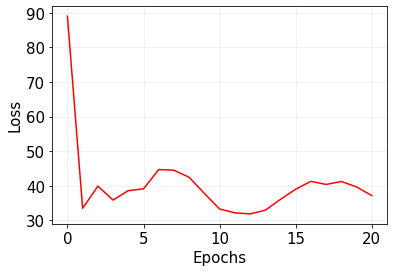

In [564]:
plt.plot(np.array(loss_t), 'r')
#plt.yscale('log')

plt.grid(alpha=.2)


plt.xlabel('Epochs')
plt.ylabel('Loss');

In [382]:
p = params_t[int(np.argmin(np.asarray(loss_t)))]
#p = params_t[-1]

#### Cmp. loss distributions

#### Div nn viz

In [565]:
#### div
def _div_nn(in_fields):
    mlp = hk.nets.MLP(DIV_HIDDEN+[1],
                      activation=jax.nn.leaky_relu,
                      activate_final=False
                     )
    out = jax.nn.sigmoid(mlp(in_fields))
    return out

_div_nn = hk.without_apply_rng(hk.transform(_div_nn))



#### sec
def _sec_nn(in_fields):
    mlp = hk.nets.MLP(SEC_HIDDEN+[params['n_chem']],
                      activation=jax.nn.leaky_relu,
                      activate_final=False
                     )
    out = jax.nn.sigmoid(mlp(in_fields))
    return out

_sec_nn = hk.without_apply_rng(hk.transform(_sec_nn))

In [566]:
xxx, yyy = np.meshgrid(np.linspace(0,10,30), np.linspace(0,10,30))
#xxx, yyy = np.meshgrid(np.linspace(-20,20,30), np.linspace(-20,20,30))

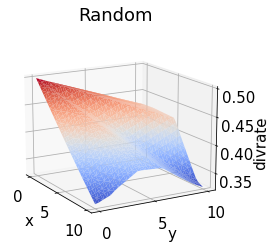

In [567]:
cc = np.vstack((xxx.flatten(),yyy.flatten()))

dd = _div_nn.apply(params['div_fn'], cc.T).flatten()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_trisurf(cc[0], cc[1], dd, linewidth=.1, antialiased=True, shade=False, cmap=plt.cm.coolwarm)

ax.view_init(15, -30)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('divrate')

ax.set_title('Random');

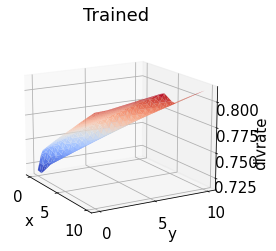

In [568]:
cc = np.vstack((xxx.flatten(),yyy.flatten()))

dd = _div_nn.apply(p['div_fn'], cc.T).flatten()

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
surf = ax.plot_trisurf(cc[0], cc[1], dd, linewidth=.1, antialiased=True, shade=False, cmap=plt.cm.coolwarm)

ax.view_init(15, -30)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('divrate')

ax.set_title('Trained');

## Initial params

In [25]:
pp = params.copy()

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, pp, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=40, key=subkey)

#print(METRIC_FN(fstate))

100%|████████████████████████████████████████████████| 40/40 [01:53<00:00,  2.83s/it]


In [26]:
fstate.celltype.sum()

DeviceArray(42., dtype=float32)

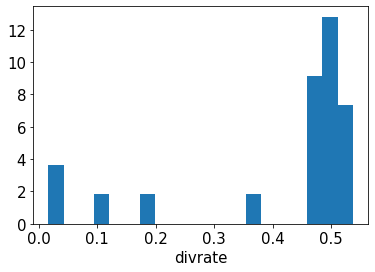

In [27]:
plt.hist(fstate.divrate.tolist(),20,density=True);
plt.xlabel('divrate');

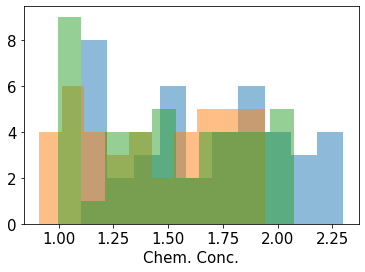

In [28]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

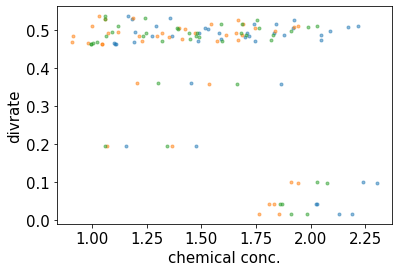

In [29]:
yy = fstate.divrate.tolist()

for chem in fstate.chemical.T.tolist():
    plt.plot(chem, yy, '.', alpha=.5)

plt.ylabel('divrate')
plt.xlabel('chemical conc.');

#plt.legend();

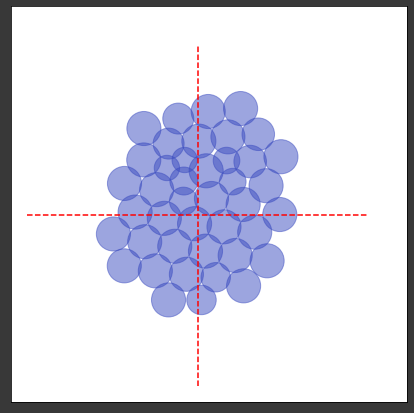

In [30]:
draw_circles_ctype(fstate);

plt.gca().plot([-5.,5.],[0.,0.],'r--');
plt.gca().plot([0.,0.],[-5.,5.],'r--');

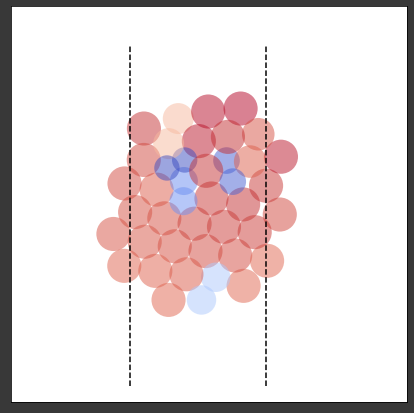

In [31]:
draw_circles_divrate(fstate);

lim = 2.

plt.gca().plot([lim,lim],[-5.,5.],'k--');
plt.gca().plot([-lim,-lim],[-5.,5.],'k--');

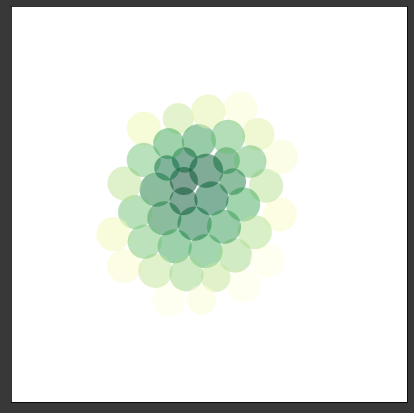

In [32]:
draw_circles_chem(fstate);

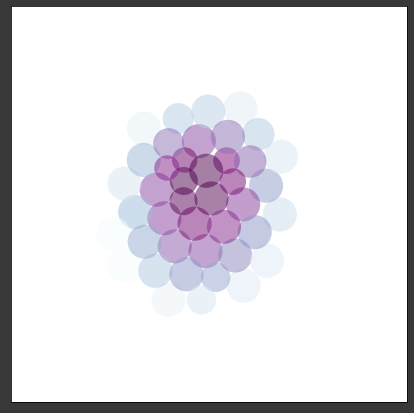

In [33]:
draw_circles_chem(fstate,1);

## Trained params

In [628]:
# merge params dicts
all_params = eqx.combine(p, hp)

key, subkey = split(key)

#forward pass - simulation
sim_init, sim_step = simulation(fstep, all_params, fspace)
fstate, _ = sim_trajectory(istate, sim_init, sim_step, ncells_add=18, key=subkey)



print(METRIC_FN(fstate))

-4


In [629]:
fstate.celltype.sum()

DeviceArray(4., dtype=float32)

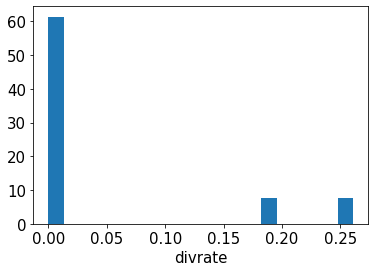

In [630]:
plt.hist(fstate.divrate.tolist(),20,density=True);
plt.xlabel('divrate');

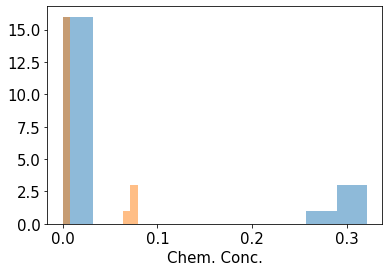

In [631]:
for chem in fstate.chemical.T.tolist():
    plt.hist(chem, alpha=.5);

plt.xlabel('Chem. Conc.');

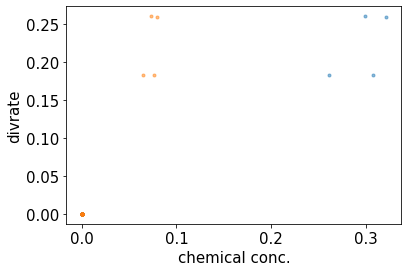

In [632]:
yy = fstate.divrate.tolist()

for chem in fstate.chemical.T.tolist():
    plt.plot(chem, yy, '.', alpha=.5)

plt.ylabel('divrate')
plt.xlabel('chemical conc.');

#plt.legend();

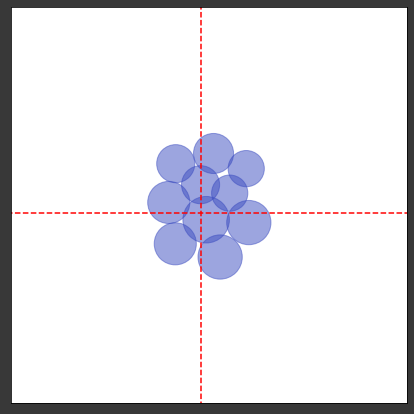

In [761]:
draw_circles_ctype(fstate);
plt.gca().plot([-5.,5.],[0.,0.],'r--');
plt.gca().plot([0.,0.],[-5.,5.],'r--');

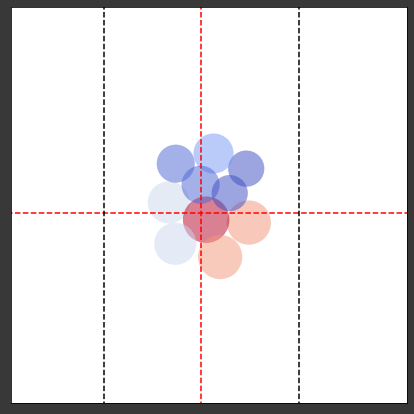

In [762]:
draw_circles_divrate(fstate);

lim = 2.

plt.gca().plot([-5.,5.],[0.,0.],'r--');
plt.gca().plot([0.,0.],[-5.,5.],'r--');

plt.gca().plot([lim,lim],[-15.,15.],'k--');
plt.gca().plot([-lim,-lim],[-15.,15.],'k--');

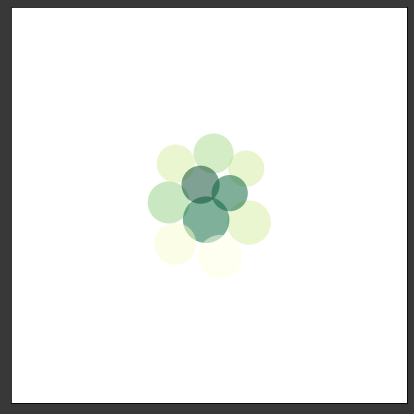

In [763]:
draw_circles_chem(fstate);

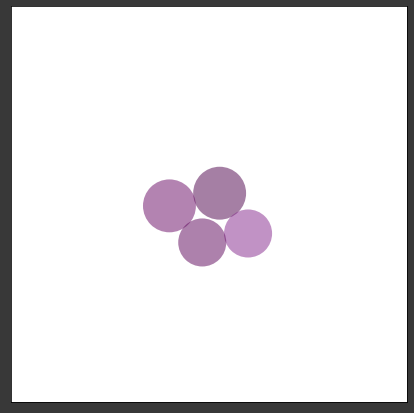

In [636]:
draw_circles_chem(fstate,1);

In [637]:
p['diffCoeff']

DeviceArray([3.626723 , 3.4615405], dtype=float32)

In [638]:
fstate.divrate

DeviceArray([0.26023528, 0.26074746, 0.1834566 , 0.18267985, 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ,
             0.        , 0.        , 0.        , 0.        , 0.        ],            dtype=float32)

# Metric shape tests

In [370]:
def xmask(state):

    mask = (state.position[:,1] > (state.position[:,0]-1)) * (state.position[:,1] < (state.position[:,0]+1))
    mask = mask + (state.position[:,1] > (-state.position[:,0]-1)) * (state.position[:,1] < (-state.position[:,0]+1))
    
    return np.where(mask,-1.,2)*np.where(state.celltype>0,1,0)

In [74]:
def xmask(state):

    mask = (state.position**2).sum(1)<3**2
    
    return np.where(mask,-1.,2)*np.where(state.celltype>0,1,0)

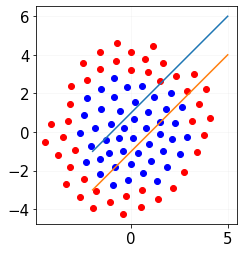

In [75]:
plt.plot(fstate.position[xmask(fstate)>0].T[0].tolist(), fstate.position[xmask(fstate)>0].T[1].tolist(),'ro')
plt.plot(fstate.position[xmask(fstate)<0].T[0].tolist(), fstate.position[xmask(fstate)<0].T[1].tolist(),'bo')

plt.gca().set_aspect('equal')

plt.grid(alpha=.1)

x = np.linspace(-2,5)

plt.plot(x, x+1)
plt.plot(x, x-1);

# TESTS

In [35]:
# mask only cells that exist
c_alive = fstate.celltype>0.

# displacements between cell pairs (ncells x ncells x ndim_space)
disp = vmap(vmap(fspace.displacement, in_axes=[0,None]), in_axes=[None,0])(fstate.position, fstate.position)

# distances btw cell pairs
# dist w/ non-existing cells are zeroed out
dist = np.sqrt((disp**2).sum(2))*np.outer(c_alive, c_alive)

In [ ]:
neig = np.nonzero((dist<R)*(dist>.0))

In [43]:
neig=np.nonzero((dist<.8)*(dist>.0), size=50)

In [44]:
dist.size

1764

In [45]:
disp[neig]

DeviceArray([[ 0.04098618,  0.69460976],
             [-0.59643805, -0.30027735],
             [ 0.69336605, -0.02928007],
             [ 0.1823461 , -0.6176825 ],
             [ 0.30136395,  0.63379335],
             [ 0.5610943 ,  0.5032372 ],
             [-0.28254426, -0.7338948 ],
             [-0.41548517, -0.55315375],
             [-0.30446458,  0.6680331 ],
             [ 0.02326792,  0.61648566],
             [ 0.6532628 ,  0.29921132],
             [-0.01255447, -0.5902987 ],
             [-0.49721518,  0.38206345],
             [-0.41633788, -0.66461205],
             [-0.32598513,  0.6598591 ],
             [ 0.41548517,  0.55315375],
             [-0.02326792, -0.61648566],
             [ 0.62999487, -0.31727433],
             [-0.4706107 ,  0.48000765],
             [-0.52048314, -0.2344222 ],
             [ 0.62364554,  0.49370575],
             [-0.04098618, -0.69460976],
             [ 0.59643805,  0.30027735],
             [-0.6532628 , -0.29921132],
             [-0